# Preprocessing

In [40]:

import nltk
import string
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import scipy
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

nltk.download('punkt')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

train_file = "train.data.txt"
dev_file = "dev.data.txt"
test_file = "test.data.txt"

train_data = pd.read_csv('./%s.csv'%train_file,keep_default_na=False)
dev_data = pd.read_csv('./%s.csv'%dev_file,keep_default_na=False)
test_data = pd.read_csv('./%s.csv'%test_file,keep_default_na=False)

def preprocess(pd_data):
  data = pd_data.copy()
  data['main_tweet'] = data['main_tweet'].fillna('')
  data.replace('', np.nan, inplace=True)
  data.dropna(subset=['main_tweet'], inplace=True)
  data['main_tweet'] = data['main_tweet'].apply(lambda x: x.lower())
  data['main_tweet'] = data['main_tweet'].apply(lambda x: x.replace('\n', ' ')) 
  return data
le = LabelEncoder()
train_data = preprocess(train_data)
train_label = le.fit_transform(train_data['label'])

dev_data = preprocess(dev_data)
dev_label = le.transform(dev_data['label'])


tokenizer = Tokenizer(oov_token="<UNK>")
tokenizer.fit_on_texts(train_data['main_tweet'])

# Using BAG OF WORDS
train = tokenizer.texts_to_matrix(train_data['main_tweet'], mode="tfidf")
dev = tokenizer.texts_to_matrix(dev_data['main_tweet'], mode="tfidf")

test = tokenizer.texts_to_matrix(test_data['main_tweet'], mode="tfidf")




[nltk_data] Downloading package punkt to /home/kan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
import tensorflow as tf
from tensorflow.keras import losses

if tf.test.gpu_device_name(): 
  print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
  print("Please install GPU version of TF")
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss=losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(train, train_label, epochs=20, validation_data=(dev, dev_label), batch_size=10)

Please install GPU version of TF
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                482496    
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 484,609
Trainable params: 484,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
157/157 [==============================] - 1s 3ms/step - loss: 0.3008 - accuracy: 0.8627 - val_loss: 0.1511 - val_accuracy: 0.9553
Epoch 2/20
157/157 [==============================] - 0s 3ms/step - loss: 0.0151 - accuracy: 0.9987 - val_loss: 0.1245 - val_accuracy: 0.

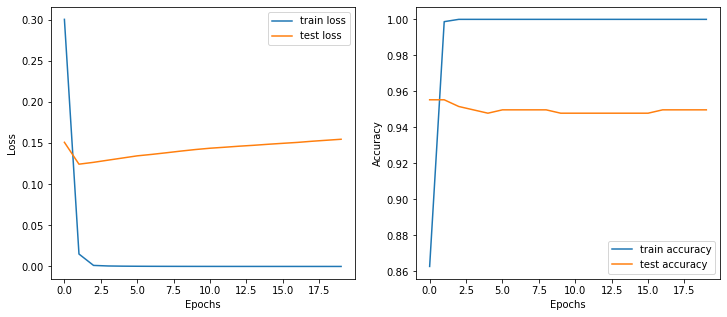

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train loss', 'test loss']);
ax = plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['train accuracy', 'test accuracy']);

In [37]:
prediction = model.predict(test)
prediction = (prediction > 0.5).astype("int32")
prediction = np.ndarray.flatten(prediction)
pd.DataFrame({"Predicted":  prediction}).to_csv('submission.csv', index_label="Id")